# PAE with SDSS Data

### step-by-step instructions for training a probabilsitic autoencoder with this package

In [1]:
# import this package 
from pytorch_pae import AE
from pytorch_pae import custom_transforms as ct

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# import pytorch
import torch
print(torch.__version__)

1.8.0


In [4]:
from torchsummary import summary
from torchvision import transforms

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
tt = transforms.Compose(
    [
        ct.RandomMask(masked_frac=0.4)
    ]
)
tt = ct.ContrastiveTransformations(tt)

## Step 1: Choose your parameters

In [7]:
SEED          = 287505

## data parameters
dataset       = 'SDSS_DR16'
loc           = '/global/cscratch1/sd/vboehm/Datasets'
# number of layers in networks
n_layers     = 1

## fully connected net specific parameters
# output size of each fully connected layer
out_sizes    = [256]

## parameters that apply to both, fully connected and convolutional nets 
# dropout rate after each layer
dropout_rate = [0.0]
# whether to Lipschitz regularize by bounding the spectral norm 
spec_norm    = False
# activation function after each layer
activations  = ['ReLU']
# whether to add a bias in each layer or not
bias         = [True]
# whether tp apply a layer normalization after conv layer
layer_norm   = [False]
# whether to train elemntwise affine parameters for normalization layer 
affine       = False

## general parameters
# data dimensionality
dim          = '1D'
# latent space dimensionality
latent_dim   = 8
hidden_dim   = 4
# number of channels in data
input_c      = 1 
# data dimensioality along one axis (only square data supported in 2D)
input_dim    = 1000
# type of encoder and decoder network (either 'fc' or 'conv')
encoder_type = 'fc'
decoder_type = 'fc'

# if True, the output is fed through a sigmoid layer to bring data values into range [0,1]
final_sigmoid = False


## Training parameters
nepochs          = 20
batchsize        = 64
batchsize_valid  = 64
initial_lr       = 1e-2

optimizer        = 'Adam'
criterion1       = 'contrastive_loss'
criterion2       = 'contrastive_loss'

scheduler        = 'ExponentialLR'
scheduler_params = {'gamma':0.98}
ann_epoch        = 500

contrastive      = True
tau              = 0.05

In [8]:
general_params      = {'input_c': input_c, 'input_dim': input_dim, 'latent_dim': latent_dim, 'encoder_type': encoder_type, 'decoder_type': decoder_type, 'dim': dim, 'contrastive':contrastive, 'hidden_dim':hidden_dim, 'tau': tau}
fc_network_params   = {'n_layers': n_layers, 'out_sizes': out_sizes,'activations': activations, 'spec_norm': spec_norm, 'dropout_rate':dropout_rate, \
                       'layer_norm': layer_norm, 'affine': affine, 'final_sigmoid': final_sigmoid, 'bias':bias}
training_params     = {'batchsize': batchsize, 'initial_lr': initial_lr, 'optimizer': optimizer, 'criterion1': criterion1, 'criterion2': criterion2,
                       'scheduler': scheduler, 'scheduler_params':scheduler_params, 'ann_epoch': ann_epoch, 'batchsize_valid': batchsize_valid}
data_params         = {'dataset':dataset, 'loc': loc}

In [9]:
torch.manual_seed(SEED)
np.random.seed(SEED)

## Step 2: Set up and train the autoencoder

In [10]:
AE1 = AE.Autoencoder(general_params,data_params,fc_network_params, fc_network_params, training_params, device, tt)

(209462, 1000, 1) 209462
(209462, 1, 1000)
(69822, 1000, 1) 69822
(69822, 1, 1000)


In [14]:
len(AE1.train_loader)*batchsize

209472

In [12]:
if dim =='1D':
    summary(AE1, (input_c,input_dim))
else:
    summary(AE1, (input_c, input_dim, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 1000]               0
            Linear-2                  [-1, 256]         256,256
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                    [-1, 8]           2,056
         FCEncoder-6                    [-1, 8]               0
              ReLU-7                    [-1, 8]               0
            Linear-8                    [-1, 6]              54
              ReLU-9                    [-1, 6]               0
           Linear-10                    [-1, 4]              28
Total params: 258,394
Trainable params: 258,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.99
Estimated T

In [13]:
train_loss, valid_loss = AE1.train(nepochs)

epoch: 0, training loss: 1.8860e+00, validation loss: 1.6008e+00, learning rate: 9.8000e-03
epoch: 1, training loss: 1.5873e+00, validation loss: 1.4673e+00, learning rate: 9.6040e-03
epoch: 2, training loss: 1.5364e+00, validation loss: 1.3478e+00, learning rate: 9.4119e-03
epoch: 3, training loss: 1.5098e+00, validation loss: 1.4597e+00, learning rate: 9.2237e-03
epoch: 4, training loss: 1.4938e+00, validation loss: 1.4571e+00, learning rate: 9.0392e-03
epoch: 5, training loss: 1.4779e+00, validation loss: 1.3488e+00, learning rate: 8.8584e-03
epoch: 6, training loss: 1.4678e+00, validation loss: 1.4016e+00, learning rate: 8.6813e-03


KeyboardInterrupt: 

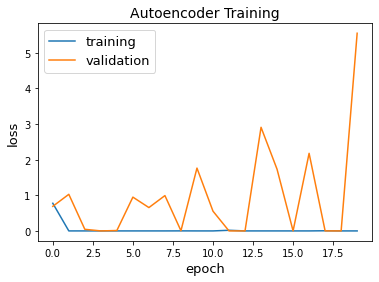

In [14]:
plt.figure()
plt.title('Autoencoder Training',fontsize=14)
plt.plot(train_loss, label='training')
plt.plot(valid_loss, label='validation')
plt.xlabel('epoch',fontsize=13)
plt.ylabel('loss',fontsize=13)
plt.legend(fontsize=13)
plt.show()